Neural Point Process

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from skimage import io, transform
from functools import lru_cache
from tools.plot_utils import visualize_pins, plot_label_pin, plot_all
from tools.data_utils import count_all, count_pins
import matplotlib.pyplot as plt
from torch_lr_finder import LRFinder

# Dataset and Visualization

In [2]:
# Set a random seed for PyTorch
seed = 4  # You can use any integer value as the seed
torch.manual_seed(seed)
# Set a random seed for NumPy (if you're using NumPy operations)
np.random.seed(seed)

In [3]:
dataset = "PinMNIST" 
n = 500
mesh = False
d = 4
n_pins = 20
# fixed_pins = True
r = 3
d1,d2 = 28,28

if dataset == "PinMNIST":
    if mesh:
        data_folder = f"./data/MNIST_{n}images_mesh_{d}step_{28}by{28}pixels_{r}radius_{seed}seed"
    else:
        data_folder = f"./data/MNIST_{n}images_random_fixed{fixed_pins}_{n_pins}pins_{28}by{28}pixels_{r}radius_{seed}seed"

if dataset == "Synthetic":
    if mesh:
        data_folder = f"./data/Synthetic_{n}images_{d1}by{d2}pixels_{d}_distanced_grid_pins_{seed}seed/"
    else:
        data_folder = f"./data/Synthetic_{n}images_{d1}by{d2}pixels_upto{n_pins}pins_{seed}seed/"
        
    
    
# data_folder = f"./data/MNIST_{n}images_mesh_{d}step_{28}by{28}pixels_{r}radius_{seed}seed"
# data_folder = "./data/Synthetic_100images_32by32pixels_upto500pins_4seed"

In [4]:
class PinDataset(Dataset):
    """Synthetic Heatmaps dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pins_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.pins_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.pins_frame.iloc[idx, 0])
        image = io.imread(img_name)
        pins = np.asarray(eval(self.pins_frame.iloc[idx, 1]))
        outputs = np.asarray(eval(self.pins_frame.iloc[idx, 2]))

        sample = {'image': image, 'pins': pins, 'outputs': outputs}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, pins, outputs = sample['image'], sample['pins'], sample['outputs']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        if len(image.shape) == 2:
            image = image.reshape(image.shape[0], image.shape[1], 1)
        image = image.transpose((2, 0, 1))
        image = image/image.max()
        return {'image': torch.from_numpy(image),
                'pins': torch.from_numpy(pins),
                'outputs': torch.from_numpy(outputs).to(torch.float32)}
    
# Define a custom transform to resize the image
class Resize(object):
    def __call__(self, sample, size=(28,28)):
        image, pins, outputs = sample['image'], sample['pins'], sample['outputs']
        
        # Resize the image to desired sized pixels
        image = transforms.functional.resize(image, size)
        
        return {'image': image, 'pins': pins, 'outputs': outputs}

# Create a transform pipeline that includes the resizing step
if dataset == "PinMNIST":
    transform = transforms.Compose([
        ToTensor(),         # Convert to tensor (as you were doing)
        Resize()  # Resize to 100x100
    ])

    transformed_dataset = PinDataset(csv_file=f"{data_folder}/pins.csv",
                                          root_dir=f"{data_folder}/images/",
                                          transform=transform)
elif dataset == "Synthetic":
    transform = transforms.Compose([
        ToTensor(),         # Convert to tensor (as you were doing)
        Resize(size=(128,128))  # Resize to 100x100
    ])

    transformed_dataset = SynthHeatmapDataset(csv_file=f"{data_folder}/pins.csv",
                                          root_dir=f"{data_folder}/images/",
                                          transform=transform)

In [5]:
dataset_size = len(transformed_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    transformed_dataset, [train_size, val_size, test_size]
)

# Define batch size
batch_size = 64

def custom_collate_fn(batch):
    images = [sample['image'] for sample in batch]
    pins = [sample['pins'] for sample in batch]
    outputs = [sample['outputs'] for sample in batch]


    return {
        'image': torch.stack(images, dim=0),
        'pins': pins,
        'outputs': outputs}

# Create your DataLoader with the custom_collate_fn
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)

In [6]:
for batch in train_dataloader:
    images = batch['image']  # get RGB instead of RGBA
    pins = batch['pins']     
    outputs = batch['outputs']  
    # print(images.shape, len(pins), len(outputs))
    # Your training or evaluation code here


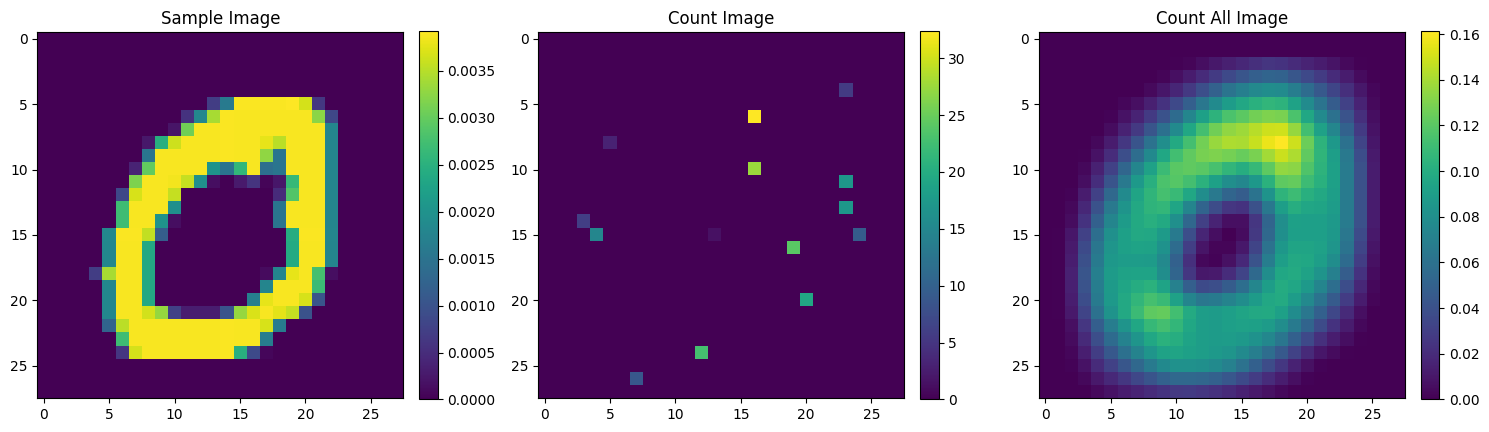

In [7]:
sample_img = images[0].squeeze().detach().cpu()/255
count_image = plot_label_pin(sample_img, pins[0], outputs[0])
# label = count_pins(sample_img, pins[0], r)
# count_all_image = plot_label_pin(sample_img,pins[0], label)
count_all_image = plot_all(sample_img, r=3)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # You can adjust the figsize as needed

# Plot the sample_img in the first subplot
im0 = axes[0].imshow(sample_img)
axes[0].set_title('Sample Image')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)  # Add colorbar

# Plot the count_image in the second subplot
im1 = axes[1].imshow(count_image)
axes[1].set_title('Count Image')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)  # Add colorbar

# Plot the count_all_image in the third subplot
im2 = axes[2].imshow(count_all_image)
axes[2].set_title('Count All Image')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)  # Add colorbar

# Add spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

# Loss function

In [8]:
def gaussian_kernel_matrix(X, Y, sigma):
    """
    Calculate the Gaussian kernel matrix between two sets of PyTorch tensors X and Y.

    Parameters:
    X (torch.Tensor): First set of tensors with shape (n, d), where n is the number of vectors and d is the dimensionality.
    Y (torch.Tensor): Second set of tensors with shape (m, d), where m is the number of vectors and d is the dimensionality.
    sigma (float): The kernel bandwidth parameter.

    Returns:
    torch.Tensor: The Gaussian kernel matrix of shape (n, m).
    """
    if X.size(1) != Y.size(1):
        raise ValueError("Input tensors must have the same dimension")

    n, m = X.size(0), Y.size(0)
    X = X.unsqueeze(1)  # Shape (n, 1, d)
    Y = Y.unsqueeze(0)  # Shape (1, m, d)

    diff = torch.norm(X - Y, dim=2)  # Pairwise Euclidean distances between vectors
    return torch.exp(- (diff ** 2) / (2 * sigma ** 2))


def pseudo_inverse(kernel_matrix, epsilon=1e-5):
    """
    Calculate the pseudo-inverse of a matrix using Singular Value Decomposition (SVD).

    Parameters:
    kernel_matrix (torch.Tensor): The matrix for which to compute the pseudo-inverse.
    epsilon (float): A small value to avoid division by zero.

    Returns:
    torch.Tensor: The pseudo-inverse of the input matrix.
    """
    U, S, V = torch.svd(kernel_matrix)
    S_inv = 1.0 / (S + epsilon)
    pseudo_inv = torch.mm(V, torch.mm(torch.diag(S_inv), U.t()))
    return pseudo_inv


class NPPLoss(nn.Module):
    def __init__(self, identity, sigma=1.0):
        super(NPPLoss, self).__init__()
        self.identity = identity
        self.sigma = sigma  # Add sigma as an instance variable
    
    @lru_cache(maxsize=None)
    def compute_kernel(self, pins):
        matrix_list = []
        for i in range(len(pins)):
            X = Y = pins[i].float()
            kernel_matrix = gaussian_kernel_matrix(X, Y, self.sigma)  # Use self.sigma
            pseudo_inv_matrix = pseudo_inverse(kernel_matrix)
            matrix_list.append(pseudo_inv_matrix)
        return matrix_list
    
    def forward(self, y_true, y_pred, pins):
        loss = 0
        if self.identity:
            for i in range(len(y_true)):
                loss += 1/len(y_true[i]) * torch.matmul(
                    (y_true[i] - y_pred[i].squeeze()[pins[i][:,0], pins[i][:,1]]).t(),
                    (y_true[i] - y_pred[i].squeeze()[pins[i][:,0], pins[i][:,1]])
                )
        else:
            matrix_list = self.compute_kernel(tuple(pins))
            for i in range(len(y_true)):
                loss += 1/len(y_true[i]) * torch.matmul(
                    (y_true[i] - y_pred[i].squeeze()[pins[i][:,0], pins[i][:,1]]).t(),
                    torch.matmul(matrix_list[i], y_true[i] - y_pred[i].squeeze()[pins[i][:,0], pins[i][:,1]])
                )
        loss /= len(y_true)
        return loss


# Neural Networks

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, num_kernels_encoder, num_kernels_decoder, input_channel=3):
        super(Autoencoder, self).__init__()
        self.input_channel = input_channel
        self.encoder = self._build_encoder(num_kernels_encoder)
        self.decoder = self._build_decoder(num_kernels_decoder, num_kernels_encoder[-1])
        
    def _build_encoder(self, num_kernels):
        layers = []
        
        for out_channels in num_kernels:
            layers.append(nn.Conv2d(self.input_channel, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.input_channel = out_channels  # Update input_channel for the next layer
        
        return nn.Sequential(*layers)
    
    def _build_decoder(self, num_kernels, input_channel):
        layers = []
        
        for out_channels in num_kernels:
            layers.append(nn.ConvTranspose2d(input_channel, out_channels, kernel_size=2, stride=2))
            layers.append(nn.ReLU())
            input_channel = out_channels
        
        layers.append(nn.ConvTranspose2d(input_channel, 1, kernel_size=2, stride=2))
        layers.append(nn.ReLU())
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [10]:
class EarlyStoppingCallback:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = float('inf')

    def __call__(self, epoch, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"Early stopping after {epoch} epochs.")
                return True  # Stop training
        return False  # Continue training

    


# Training

In [11]:
class CustomLRFinder:
    def __init__(self, model, criterion, optimizer, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.history = {'lr': [], 'loss': []}

    def find_lr(self, train_loader, start_lr=1e-7, end_lr=10, num_iter=100, smooth_f=0.05):
        model = self.model.to(self.device)
        criterion = self.criterion
        optimizer = self.optimizer
        device = self.device
        model.train()

        lr_step = (end_lr / start_lr) ** (1 / num_iter)
        lr = start_lr

        for iteration in range(num_iter):
            optimizer.param_groups[0]['lr'] = lr

            total_loss = 0.0
            for batch in train_loader:
                x_train = batch['image'][:, :input_channel, :, :].to(device)
                p_train = [tensor.to(device) for tensor in batch['pins']]
                y_train = [tensor.to(device) for tensor in batch['outputs']]

                optimizer.zero_grad()
                outputs = model(x_train.float())
                loss = criterion(y_train, outputs, p_train)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            self.history['lr'].append(lr)
            self.history['loss'].append(avg_loss)

            lr *= lr_step

    def find_best_lr(self, skip_start=10, skip_end=5):
        # Find the index of the minimum loss in the specified range
        min_loss_index = skip_start + np.argmin(self.history['loss'][skip_start:-skip_end])

        # Output the learning rate corresponding to the minimum loss
        best_lr = self.history['lr'][min_loss_index]
        return best_lr





In [12]:
def train_model(model, train_dataloader, val_dataloader, num_epochs, val_every_epoch, learning_rate, criterion, optimizer, device, early_stopping):
    train_losses = []  # To track train loss for plotting
    val_losses = []    # To track validation loss for plotting
    best_val_loss = float('inf') 

    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_dataloader:
            x_train = batch['image'][:, :input_channel, :, :].to(device)
            p_train = [tensor.to(device) for tensor in batch['pins']]
            y_train = [tensor.to(device) for tensor in batch['outputs']] 

            # Forward pass
            outputs = model(x_train.float())
            loss = criterion(y_train, outputs, p_train)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        total_loss /= len(train_dataloader.dataset)
        # Print train loss
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {total_loss:.4f}')
        train_losses.append(total_loss)

        # Check validation loss every val_every_epoch epochs
        if (epoch) % val_every_epoch == 0:
            val_loss = 0.0
            with torch.no_grad():
                for val_batch in val_dataloader:
                    x_val = val_batch['image'][:, :input_channel, :, :].to(device)
                    p_val = [tensor.to(device) for tensor in val_batch['pins']]
                    y_val = [tensor.to(device) for tensor in val_batch['outputs']]

                    val_outputs = model(x_val.float())
                    val_loss += criterion(y_val, val_outputs, p_val).item()

            val_loss /= len(val_dataloader.dataset)  # Average validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save the model
                torch.save(model.state_dict(), 'best_model.pth')

            if early_stopping(epoch, val_loss):
                break  # Stop training early
            print(f'Validation Loss: {val_loss:.4f}')
            val_losses.append(val_loss)

    # Reload the best model after training
    model.load_state_dict(torch.load('best_model.pth'))

    return model, train_losses, val_losses



# Evaluation

In [13]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    metric = NPPLoss(identity=True).to(device)
    
    with torch.no_grad():
        for batch in dataloader:
            x_test = batch['image'][:, :input_channel, :, :].to(device)
            p_test = [tensor.to(device) for tensor in batch['pins']]
            y_test = [tensor.to(device) for tensor in batch['outputs']]

            test_outputs = model(x_test.float())
            loss = metric(y_test, test_outputs, p_test)

            total_loss += loss.item()

    total_loss /= len(dataloader.dataset)
    return total_loss

def plot_loss(train_losses, val_losses, val_every_epoch, NPP, sigma, dataset, learning_rate, num_kernels_encoder, num_kernels_decoder, save_dir="./results/plots"):
    # Create a directory for saving plots if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Construct the filename based on parameters
    filename = f"loss_plot_NPP_{NPP}_sigma_{sigma}_dataset_{dataset}_lr_{learning_rate}_encoder_{num_kernels_encoder}_decoder_{num_kernels_decoder}.png"
    save_path = os.path.join(save_dir, filename)

    # Plot the train and validation loss
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(val_every_epoch, len(train_losses), val_every_epoch), val_losses, '--', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('MSE Loss')
    plt.legend()

    # Save the plot
    plt.savefig(save_path)
    plt.close()


In [14]:
def plot_and_save(loss_vs_sigma_data, sigmas, dataset, learning_rate, model_name="Auto encoder"):
    # Unpack the data
    test_loss_npp_true, test_loss_npp_false= loss_vs_sigma_data

    # Calculate mean and confidence intervals for NPP=True runs
    mean_test_loss_npp_true = np.mean(test_loss_npp_true, axis=0)
    ci_test_loss_npp_true = 1.96 * np.std(test_loss_npp_true, axis=0) / np.sqrt(len(test_loss_npp_true))

    # Plot mean and confidence intervals for NPP=True
    plt.errorbar(sigmas, mean_test_loss_npp_true, yerr=ci_test_loss_npp_true, marker='o', label='NPP=True')

    # Plot NPP=False
    plt.axhline(y=np.mean(test_loss_npp_false_runs), color='r', linestyle='--', label='NPP=False')

    plt.xscale('log')
    plt.xlabel('Sigma (log scale)')
    plt.yscale('log') 
    plt.ylabel('Test Loss (log scale)')
    plt.title(f'Test Loss vs. Sigma: {dataset} dataset with {model_name}')
    plt.legend()

    # Create a directory to save the results if it doesn't exist
    results_dir = './results'
    os.makedirs(results_dir, exist_ok=True)

    # Generate a filename based on parameters in the title
    filename = f"test_loss_vs_sigma_{dataset}_{model_name}_lr_{learning_rate}.png"
    filepath = os.path.join(results_dir, filename)

    # Save the plot
    plt.savefig(filepath)

    # Show the plot
    plt.show()
    

def run_pipeline_ci(input_channel, train_dataloader, val_dataloader, num_epochs, val_every_epoch, learning_rate, device, num_runs=5):
    test_losses_npp_true = []
    test_losses_npp_false= []

    for run in range(num_runs):
        test_losses_vs_sigma_npp_true = []
        test_loss_npp_false = None

        # Run NPP=False once and collect the test loss
        early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.001)
        criterion = NPPLoss(identity=True).to(device)

        autoencoder = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
        
        optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
        model, train_losses, val_losses = train_model(autoencoder, train_dataloader, val_dataloader, num_epochs, val_every_epoch, learning_rate, criterion, optimizer, device, early_stopping)

        test_loss_npp_false = evaluate_model(autoencoder, test_dataloader, device)
        test_losses_npp_false.append(test_loss_npp_false)

        # Run LR Finder for different sigma values
        for sigma in sigmas:
            early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.001)
            criterion = NPPLoss(identity=False, sigma=sigma).to(device)
            autoencoder = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
            optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
            model, train_losses, val_losses = train_model(autoencoder, train_dataloader, val_dataloader, num_epochs, val_every_epoch, learning_rate, criterion, optimizer, device, early_stopping)
            test_loss = evaluate_model(autoencoder, test_dataloader, device)
            test_losses_vs_sigma_npp_true.append(test_loss)

        test_losses_npp_true.append(test_losses_npp_true)
    return test_loss_npp_true, test_loss_npp_false_runs

def save_data(data, filename):
    np.save(filename, data)

# Function to load data
def load_data(filename):
    return np.load(filename)

# Function to run the pipeline and save data
def run_and_save_pipeline(input_channel, train_dataloader, val_dataloader, num_epochs, val_every_epoch, learning_rate, device):
    # Run the pipeline
    test_loss_npp_true, test_loss_npp_false= run_pipeline_ci(input_channel, train_dataloader, val_dataloader, num_epochs, val_every_epoch, learning_rate, device)

    # Save the data
    save_data(test_loss_npp_true, 'test_loss_npp_true.npy')
    save_data(test_loss_npp_false_runs, 'test_loss_npp_false_runs.npy')

    return test_loss_npp_true, test_loss_npp_false_runs

In [15]:
# Set your hyperparameters
dataset = "MNIST"
input_channel = 1 if dataset == "MNIST" else 3
num_epochs = 200
sigmas = [0.1, 0.2, 0.5, 1, 2, 3]  # Set the sigma values you want to test
num_kernels_encoder = [16, 8]
num_kernels_decoder = [16]
learning_rate = 0.03
val_every_epoch = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run and save the pipeline data
loss_vs_sigma_data = run_and_save_pipeline(input_channel, train_dataloader, val_dataloader, num_epochs, val_every_epoch, learning_rate, device)

# Plot and save the plot using the saved data
plot_and_save(loss_vs_sigma_data, sigmas, dataset, learning_rate)

Epoch [1/200], Train Loss: 1.2927
Validation Loss: 0.7211
Epoch [2/200], Train Loss: 0.5416
Epoch [3/200], Train Loss: 0.3619
Epoch [4/200], Train Loss: 0.2739
Epoch [5/200], Train Loss: 0.2346
Epoch [6/200], Train Loss: 0.2149
Validation Loss: 0.2573
Epoch [7/200], Train Loss: 0.1938
Epoch [8/200], Train Loss: 0.1712
Epoch [9/200], Train Loss: 0.1512
Epoch [10/200], Train Loss: 0.1300
Epoch [11/200], Train Loss: 0.1139
Validation Loss: 0.1415
Epoch [12/200], Train Loss: 0.1070
Epoch [13/200], Train Loss: 0.0958
Epoch [14/200], Train Loss: 0.0839
Epoch [15/200], Train Loss: 0.0760
Epoch [16/200], Train Loss: 0.0706
Validation Loss: 0.0893
Epoch [17/200], Train Loss: 0.0687
Epoch [18/200], Train Loss: 0.0652
Epoch [19/200], Train Loss: 0.0625
Epoch [20/200], Train Loss: 0.0621
Epoch [21/200], Train Loss: 0.0618
Validation Loss: 0.0831
Epoch [22/200], Train Loss: 0.0605
Epoch [23/200], Train Loss: 0.0578
Epoch [24/200], Train Loss: 0.0554
Epoch [25/200], Train Loss: 0.0528
Epoch [26/200]

NameError: name 'test_loss_npp_true' is not defined

In [ ]:
test_loss_npp_true, test_loss_npp_false= loss_vs_sigma_data
test_loss_npp_false = [test_loss_npp_false for i in range((len(sigmas)))]
test_loss_npp_true,test_loss_npp_false

In [ ]:
def plot_and_save(loss_vs_sigma_data, sigmas, dataset, learning_rate, model_name="Auto encoder"):
    # Unpack the data
    test_loss_npp_true, test_loss_npp_false = loss_vs_sigma_data
    test_loss_npp_false = [test_loss_npp_false for i in range(len(sigmas))]

    # Calculate mean and confidence intervals for NPP=True runs
    mean_test_loss_npp_true = np.mean(test_loss_npp_true, axis=0)
    ci_test_loss_npp_true = 1.96 * np.std(test_loss_npp_true, axis=0) / np.sqrt(len(test_loss_npp_true))

    # Duplicate NPP=False values for plotting
    mean_test_loss_npp_false = np.mean(test_loss_npp_false, axis=1)
    ci_test_loss_npp_false = 1.96 * np.std(test_loss_npp_false, axis=1) / np.sqrt(len(test_loss_npp_false))

    # Plot mean and confidence intervals for NPP=True
    plt.plot(sigmas, mean_test_loss_npp_true, marker='o', label='NPP=True', color='blue')

    # Plot mean and confidence intervals for duplicated NPP=False
    plt.plot(sigmas, mean_test_loss_npp_false, marker='o', color='red', linestyle='--', label='NPP=False')

    # Fill between for NPP=True with blue color
    plt.fill_between(sigmas, mean_test_loss_npp_true - ci_test_loss_npp_true, mean_test_loss_npp_true + ci_test_loss_npp_true, color='blue', alpha=0.2)

    # Fill between for NPP=False with red color
    plt.fill_between(sigmas, mean_test_loss_npp_false - ci_test_loss_npp_false, mean_test_loss_npp_false + ci_test_loss_npp_false, color='red', alpha=0.2)

    plt.xlabel('Sigma')
    plt.ylabel('Test Loss')
    plt.title(f'Test Loss vs. Sigma:{dataset} dataset with {model_name}')
    plt.legend()

    # Create a directory to save the results if it doesn't exist
    results_dir = './results'
    os.makedirs(results_dir, exist_ok=True)

    # Generate a filename based on parameters in the title
    filename = f"test_loss_vs_sigma_{dataset}_{model_name}_lr_{learning_rate}.png"
    filepath = os.path.join(results_dir, filename)

    # Save the plot
    plt.savefig(filepath)

    # Show the plot
    plt.show()

# Example usage:
# plot_and_save(loss_vs_sigma_data, sigmas, dataset, learning_rate)



    
# Plot and save the plot using the saved data
plot_and_save(loss_vs_sigma_data, sigmas, dataset, learning_rate)

# Visualization

In [ ]:
def plot_results(x, p, y, outputs, r):
    plt.figure(figsize=(14, 14))  # Adjust the figure size
    n_shows = 4

    for i in range(n_shows):
        # Original Images
        img = x[i].squeeze().detach().cpu() / 255

        plt.subplot(4, 4, 4*i+1 )
        plt.imshow(img)

        plt.subplot(4, 4, 4*i + 2)  # Transposed the rows and columns
        count_all_image = plot_all(img, r=r)
        plt.imshow(count_all_image)

        # Reconstructed Images (switched with row 3)
        plt.subplot(4, 4, 4*i + 3)  # Transposed the rows and columns
        count_image = plot_label_pin(img, p[i], y[i])
        plt.imshow(count_image)

        plt.subplot(4, 4, 4*i + 4)
        plt.imshow(outputs[i].squeeze().detach().cpu())

    # Add an overall color bar
    plt.subplots_adjust(bottom=0.2, hspace=0.4)  # Increase the vertical spacing
    cbar_ax = plt.gcf().add_axes([0.15, 0.1, 0.7, 0.03])  # Define the position and size of the color bar
    cbar = plt.colorbar(cax=cbar_ax, orientation='horizontal')

    # Add titles in the middle of the entire row
    plt.subplot(4, 4, 1).set_title("images", position=(0.5, 1.05))
    plt.subplot(4, 4, 2).set_title("Label all map", position=(0.5, 1.05))
    plt.subplot(4, 4, 3).set_title("Label pins", position=(0.5, 1.05))
    plt.subplot(4, 4, 4).set_title("Predicted", position=(0.5, 1.05))

    # Define the output folder based on the dataset
    output_folder = f"results/{dataset}"
    os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

    # Define the image filename based on parameters
    image_filename = f"NPP{NPP}_LR={learning_rate}_n={n}_mesh={mesh}_d={d}_n_pins={n_pins}_fixedpins={fixed_pins}_r={r}.png"

    # Save the figure as a high-resolution PNG in the specified folder
    plt.savefig(os.path.join(output_folder, image_filename), dpi=100)

    plt.show()


In [ ]:
def visualize_samples(dataloader, autoencoder):
    with torch.no_grad():
        for batch in dataloader:
            x = batch['image'][:, :input_channel, :, :].to(device)
            p = [tensor.to(device) for tensor in batch['pins']]
            y = [tensor.to(device) for tensor in batch['outputs']]

            outputs = autoencoder(x.float())
            break
    plot_results(x, p, y, outputs, r=r)
    

# visualize_samples(test_dataloader, autoencoder)